In [1]:
# Install the necessary packages
!pip install datasets
!pip install tokenizers
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import AutoTokenizer
from tokenizers import Tokenizer
from tokenizers.models import WordLevel, WordPiece, BPE, Unigram 
from tokenizers.pre_tokenizers import WhitespaceSplit, CharDelimiterSplit, BertPreTokenizer
from tokenizers.trainers import WordLevelTrainer, BpeTrainer, UnigramTrainer, WordLevelTrainer, WordPieceTrainer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [3]:
# constants
VOCAB_SIZE = 20000

In [4]:
# Load the SST dataset
dataset_train = load_dataset('sst', split='train')
dataset_dev = load_dataset('sst', split='validation')
dataset_test = load_dataset('sst', split='test')

# Print some examples from the dataset
print(dataset_train[0]["sentence"])
print(dataset_train[0]["label"])

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
0.6944400072097778


# Data preprocessing and visualization

In [5]:
# Convert the dataset to a pandas DataFrame
df_train = pd.DataFrame(dataset_train)[['sentence', 'label']]
df_dev = pd.DataFrame(dataset_dev)[['sentence', 'label']]
df_test = pd.DataFrame(dataset_test)[['sentence', 'label']]

In [6]:
# Round the label column to 0 or 1
for df in [df_train, df_dev, df_test]:
  df['label'] = df['label'].apply(lambda x: round(x))

df_train.head()

,sentence,label
0,The Rock is destined to be the 21st Century 's...,1
1,The gorgeously elaborate continuation of `` Th...,1
2,Singer\/composer Bryan Adams contributes a sle...,1
3,You 'd think by now America would have had eno...,0
4,Yet the act is still charming here .,1


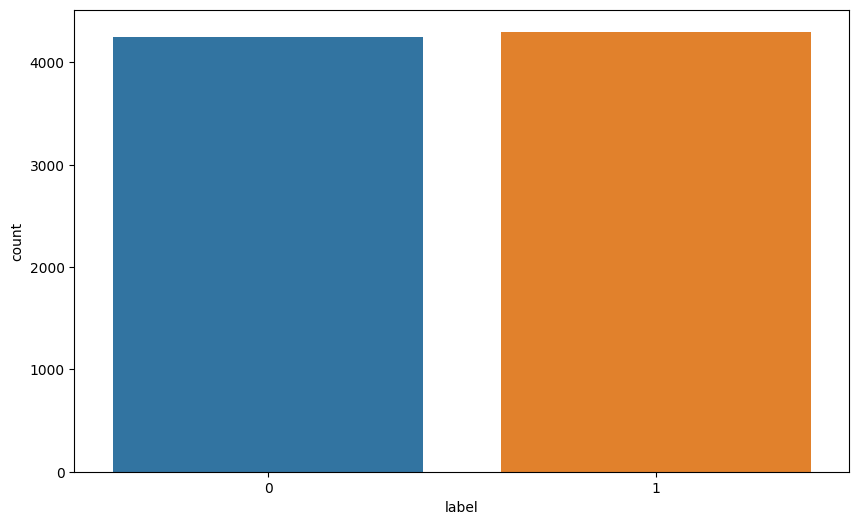

In [7]:
# Visualizing the distribution of the target variable
plt.figure(figsize=(10,6))
sns.countplot(x='label', data=df_train)

plt.show()

# Tokenization

In [8]:
# load the tokenizers:
bpe = Tokenizer(BPE(unk_token="[UNK]"))
wordPiece = Tokenizer(WordPiece(unk_token="[UNK]"))
unigram = Tokenizer(Unigram())
# need to complete the random freqs bpe

In [9]:
# load the preTokenizers:
bpe.pre_tokenizer = BertPreTokenizer()
wordPiece.pre_tokenizer = BertPreTokenizer()
unigram.pre_tokenizer = BertPreTokenizer()
# need to complete the random freqs bpe

In [10]:
# load the default trainers:
bpe_trainer = BpeTrainer(special_tokens=["<PAD>", "<UNK>"], vocab_size=VOCAB_SIZE)
wordPiece_trainer = WordPieceTrainer(special_tokens=["<PAD>", "<UNK>"], vocab_size=VOCAB_SIZE)
unigram_trainer = UnigramTrainer(special_tokens=["<PAD>", "<UNK>"], vocab_size=VOCAB_SIZE)
# need to complete the random freqs bpe

In [11]:
# train the tokenizers on the corpus
corpus = pd.concat([df_train["sentence"],df_dev["sentence"],df_test["sentence"]])

bpe.train_from_iterator(corpus, trainer=bpe_trainer)
wordPiece.train_from_iterator(corpus, trainer=wordPiece_trainer)
unigram.train_from_iterator(corpus, trainer=unigram_trainer)

In [12]:
class CharTokenizer:
    def encode(self, text):
        tokens = [char for char in text]
        class Tokens:
            def __init__(self, tokens):
                self.tokens = tokens
        return Tokens(tokens)

In [13]:
by_char = CharTokenizer()

In [14]:
print(bpe.get_vocab_size())
print(wordPiece.get_vocab_size())
print(unigram.get_vocab_size())

20000
20000
10858


In [15]:
print(' '.join(bpe.encode("hello world").tokens))
print(' '.join(wordPiece.encode("hello world").tokens))
print(' '.join(unigram.encode("hello world").tokens))
print(' '.join(by_char.encode("hello world").tokens))

hel lo world
hell ##o world
hell o world
h e l l o   w o r l d


In [22]:
# create the list of tokenizers
tokenizers = {'bpe':bpe, 'wordPiece':wordPiece,'unigram':unigram} # need to add by_char and random_freq_bpe

# Tokenize the text in the DataFrame
for df in [df_train, df_dev, df_test]:
  for tokenizer_name,tokenizer in tokenizers.items():
    df[f"tokenized_by_{tokenizer_name}"] = df['sentence'].apply(lambda x: ' '.join(tokenizer.encode(x).tokens))

In [23]:
df_train.head()

,sentence,label,tokenized_by_bpe,tokenized_by_wordPiece,tokenized_by_unigram,tokenized_by_by_char
0,The Rock is destined to be the 21st Century 's...,1,The Rock is destined to be the 21st Century ' ...,The Rock is destined to be the 21st Century ' ...,The Rock is destin ed to be the 21 s t C entur...,T h e R o c k i s d e s t i n e d t o ...
1,The gorgeously elaborate continuation of `` Th...,1,The gorgeously elaborate continuation of ` ` T...,The gorgeously elaborate continuation of ` ` T...,The gorgeous ly elaborate continu ation of ` `...,T h e g o r g e o u s l y e l a b o r a t ...
2,Singer\/composer Bryan Adams contributes a sle...,1,Sing er \ / composer Bryan Adams contribut es ...,Singer \ / composer Bryan Adams contrib ##utes...,S ing er \ / compose r Br y an Adam s contribu...,S i n g e r \ / c o m p o s e r B r y a n ...
3,You 'd think by now America would have had eno...,0,You ' d think by now America would have had en...,You ' d think by now America would have had en...,You ' d think by now America w ould have had e...,Y o u ' d t h i n k b y n o w A m e ...
4,Yet the act is still charming here .,1,Yet the act is still charming here .,Yet the act is still charming here .,Ye t the act is still charming here .,Y e t t h e a c t i s s t i l l c h ...


# Bag of words

In [24]:
# Create CountVectorizer objects for each tokenizer and fit them
vectorizers = [CountVectorizer().fit(pd.concat([df_train[f"tokenized_by_{tokenizer_name}"],df_dev[f"tokenized_by_{tokenizer_name}"],df_test[f"tokenized_by_{tokenizer_name}"]])) for tokenizer_name in tokenizers.keys()]

In [27]:
vectorizers[0].transform(df_train[f"tokenized_by_{tokenizer_name}"]).toarray().shape

(8544, 15490)

In [28]:
accuracies = []
y_train, y_test = np.array(df_train['label']), np.array(df_test['label'])
for vectorizer,tokenizer_name in zip(vectorizers,tokenizers.keys()):
  X_train = vectorizer.transform(df_train[f"tokenized_by_{tokenizer_name}"]).toarray()
  X_test = vectorizer.transform(df_test[f"tokenized_by_{tokenizer_name}"]).toarray()
  # Create an instance of LogisticRegression classifier
  lr = LogisticRegression(verbose=1,solver='saga',penalty='l2')
  # Fit the model
  lr.fit(X_train, y_train)
  # Create the predictions
  y_predict = lr.predict(X_test)
  # Use metrics.accuracy_score to measure the score
  print(f"LogisticRegression Accuracy {metrics.accuracy_score(y_test, y_predict)} for {tokenizer_name}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 200 seconds


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min finished


LogisticRegression Accuracy 0.7660633484162896 for bpe


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 183 seconds
LogisticRegression Accuracy 0.7723981900452489 for wordPiece


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 106 seconds
LogisticRegression Accuracy 0.7506787330316742 for unigram


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min finished
